In [199]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [110]:
import pandas as pd

train_data = pd.read_csv("train.tsv")
test_data = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")
print(len(train_data))
print(len(test))

72457
2016


In [161]:
frac = 0.5 # fraction of learning examples used for model fitting

# sample the train set if your don't want to deel with all examples
test = test_data.drop(['Num'], axis=1).as_matrix()
test_without_id = test_data.drop(['Num','item_id'], axis=1).as_matrix()
train = train_data.sample(frac=frac, random_state=42)
X_df = train.drop(['Num','y','item_id'], axis=1)
y_df = train['y']


X = X_df.as_matrix()
y = y_df.as_matrix()

print(len(X), len(y))

36228 36228


In [149]:
train_data.head()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,0,123438,2012,52,1,20442076,4915,38056,40185,45733,...,39423,41765,52590,31452,44420,41865,52705,36102,44163,45239
1,1,58410,2012,52,1,20441997,2230,18817,20110,26368,...,22830,25230,27850,21390,27090,23170,29705,19140,22055,23200
2,2,163930,2012,52,1,20441990,5695,47480,47619,89708,...,14930,44290,46412,29320,21140,28406,65056,31886,48750,36520
3,3,53902,2012,52,1,20441989,1995,17146,20066,27070,...,15120,12480,19780,7990,8230,10650,21920,13040,9780,9630
4,4,105970,2012,52,1,20441988,6515,49262,50045,95167,...,18872,19328,37168,13570,19760,20208,34745,18442,24700,21793


In [131]:
print(test_data.head())

      Num  year  week  shift   item_id      f1      f2      f3      f4  \
0  348622  2015     3      3  20447918     960     820    1128    1801   
1  348623  2015     3      3  20447902    9086   12585   11595    9685   
2  348624  2015     3      3  20447732  115087  147287  176065  143105   
3  348625  2015     3      3  20443951   20900   24420   27068   20460   
4  348626  2015     3      3  20443944    4430    5864    3310    1853   

       f5   ...       f51     f52     f53     f54     f55     f56     f57  \
0    1045   ...      1510     580     969    1635     895    2140    1182   
1   12917   ...     22055   14235   21195   18280   18270   15851   16920   
2  202069   ...    302165  162232  221622  256605  240047  236630  206697   
3   25580   ...     39055   14445   22450   22093   31175   23355   15358   
4    2836   ...       120     130      60      30      50      20      20   

      f58     f59     f60  
0    1020    1293    1290  
1   18320   24116   21307  
2  24565

In [163]:
regressor = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=10,random_state=322)
regressor.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=322,
           verbose=0, warm_start=False)

In [116]:
preds = regressor.predict(test_without_id)

In [212]:
ITEM_INDEX = 3
PREDICT_INDEX = 63
SHIFT_INDEX = 2
WEEK_INDEX = 1

def build_dict(data):
    goods = dict()
    i = 0
    for g in data:
        if g[ITEM_INDEX] not in goods:
            goods[g[ITEM_INDEX]] = [g]
        else :
            goods[g[ITEM_INDEX]].append(g)
        i += 1
    return goods


def get_precise_prediction(clusters):
    results = []
    for i in range(len(test)):
        results.append(preds[i])
        clus = clusters.get(test[i][ITEM_INDEX])
        for v in clus:
            if v[WEEK_INDEX] - v[SHIFT_INDEX] == test[i][WEEK_INDEX] :
                results[i] = v[PREDICT_INDEX]
                break
    return results 

In [208]:
clusters = build_dict(test)
result = get_precise_prediction(clusters)

In [209]:
sample_submission['y'] = preds
sample_submission['y'] = sample_submission['y'].map(lambda x: x if x > 0 else 0.0)
sample_submission.to_csv("rf3_submision.tsv", sep=',', index=False)

In [210]:
sample_submission.head(10)

,Num,y
0,348622,2068.802738
1,348623,22776.098089
2,348624,290607.600941
3,348625,30645.157167
4,348626,361.887881
5,348627,146137.460166
6,348628,73109.294648
7,348629,71577.484614
8,348630,81959.405949
9,348631,4067.455366


In [195]:
# def check():
#     y = train['y']
#     ids = train['item_id']
#     f60 = train['f60']
#     for i in range(len(y)):
#         if ids[i] == 20449792:
            
# check()

20910.9032258 13688.2799371
12534.7096774 8802.51713704


/Users/alex/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


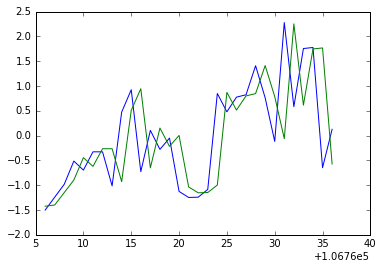

In [202]:
def get_times(fr):
    return np.array(fr['year'])*53 + (np.array(fr['week']) - 1) + np.array(fr['shift'])

def get_real_times(fr):
    return np.array(fr['year'])*53 + (np.array(fr['week']) - 1)

def print_cluster_field(train,_id,field='y',time_shift=1,norm=True,offset=0):
    trainC = train[train['item_id'] == _id][train['shift'] == time_shift]
#     trainC[('year','week','shift')].head()
    data = np.array(trainC[field])
    print(np.mean(data), np.std(data))
    if norm:
        data = (data - np.mean(data))/np.std(data)
    timeC = get_real_times(trainC)
    prepared = []
#     print(len(np.unique(timeC)), len(timeC))
    for i in range(len(timeC)):
        prepared.append((timeC[i],data[i]))
#     prepared = np.array(prepared)
    prepared = np.array(sorted(prepared))
    ox = prepared[:,0]
    oy = prepared[:,1]
    plt.plot(ox-offset,oy,label=field)
print_cluster_field(train_data,20449792)
print_cluster_field(train_data,20449792,field='f60')